In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

In [ ]:
!wget -nd -P data/ https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/bibliovid.json

--2021-01-07 23:58:54--  https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/bibliovid.json
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3850131 (3.7M) [application/json]
Saving to: ‘data/bibliovid.json’

bibliovid.json      100%[===================>]   3.67M  5.05MB/s    in 0.7s    

2021-01-07 23:58:56 (5.05 MB/s) - ‘data/bibliovid.json’ saved [3850131/3850131]



In [ ]:
!wget -nd -P data/ https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/litcovid.json

--2021-01-08 00:05:31--  https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/litcovid.json
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104815092 (100M) [application/json]
Saving to: ‘data/litcovid.json’

litcovid.json       100%[===================>]  99.96M  31.2MB/s    in 3.7s    

2021-01-08 00:05:35 (26.9 MB/s) - ‘data/litcovid.json’ saved [104815092/104815092]



In [ ]:
!wget -nd -P data/ https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/cord19-metadata.json

--2021-01-07 23:58:59--  https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/cord19-metadata.json
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 671453580 (640M) [application/json]
Saving to: ‘data/cord19-metadata.json.1’

cord19-metadata.jso   0%[                    ]  88.00K   324KB/s               ^C


## Analyse données


In [ ]:
df = pd.read_json('data/cord19-metadata.json')

In [ ]:
df.size

7480180

In [ ]:
df[~df.abstract.isna()].size

7480180

(array([ 13630.,  58309., 110896., 100244.,  56563.,  21867.,   7133.,
          2569.,   1135.,    642.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.]),
 <a list of 10 Patch objects>)

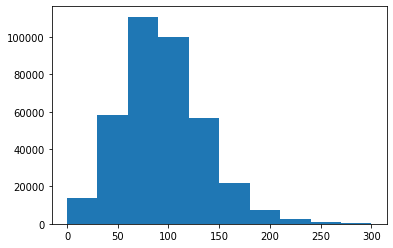

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df.title.str.len(), range=(0, 300))

(array([120547.,  33792.,  59523.,  68245.,  60759.,  19149.,   6843.,
          2646.,   1123.,    522.]),
 array([   0.,  400.,  800., 1200., 1600., 2000., 2400., 2800., 3200.,
        3600., 4000.]),
 <a list of 10 Patch objects>)

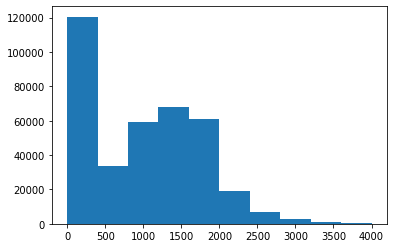

In [ ]:
plt.hist(df.abstract.str.len(), range=(0, 4000))

## Some useful classes and functions

In [ ]:
import numpy as np

import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.metrics import f1_score, accuracy_score, classification_report

import torch
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, random_split

from scipy.sparse import issparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SKLearnWrapper(ClassifierMixin, BaseEstimator):
    def __init__(self, model_class, epochs=10, batch_size=32, multilabel=False, optimizer_class=optim.Adam, **kwargs):
        self.model_class = model_class
        self.kwargs = kwargs
        self.epochs = epochs
        self.batch_size = batch_size
        self.multilabel = multilabel
        self.optimizer_class = optimizer_class

    # training the model
    def fit(self, X, y):
        self.transformer = MultiLabelBinarizer() if self.multilabel else LabelEncoder()
        y = self.transformer.fit_transform(y)
        X, y = check_X_y(X, y, accept_sparse=True, multi_output=True) # check x and y

        input_size = X.shape[1]
        output_size = y.shape[1] if self.multilabel else y.max() + 1

        self.model = self.model_class(input_size, output_size, **self.kwargs)
        self.model.to(device)

        optimizer = self.optimizer_class(self.model.parameters())
        criterion = nn.MultiLabelSoftMarginLoss() if self.multilabel else nn.CrossEntropyLoss()

        X = self._to_torch(X)
        y = self._to_torch(y)
        
        dataset = TensorDataset(X, y)
        train_size = int(0.9 * len(dataset))
        train_set, val_set = random_split(dataset, [train_size, len(dataset) - train_size])
        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            total_loss = num = 0
            self.model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_scores = self.model(x)
                loss = criterion(y_scores, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                num += len(y)
            train_loss = total_loss / num

            total_loss = num = 0
            self.model.eval()
            for x, y in val_loader:
                with torch.no_grad():
                    x, y = x.to(device), y.to(device)
                    y_scores = self.model(x)
                    loss = criterion(y_scores, y)
                    total_loss += loss.item()
                    num += len(y)
            val_loss = total_loss / num

            print(epoch, train_loss, val_loss)

        self.is_fitted_ = True
        return self

    # predict values
    def predict(self, X, return_torch=False):
        check_is_fitted(self, 'is_fitted_') # check if model is fitted
        X = check_array(X, accept_sparse=True)
        X = self._to_torch(X).to(device)
        loader = DataLoader(TensorDataset(X), batch_size=self.batch_size)
        y = []
        self.model.eval()
        with torch.no_grad():
            for x in loader:
                x = torch.vstack(x)
                y.append(self.model(x).cpu())
        y = torch.vstack(y)
        return y if return_torch else y.numpy()

    @staticmethod
    def _to_torch(X):
        if issparse(X):
            Xcoo = X.tocoo()
            return torch.sparse.FloatTensor(torch.LongTensor([Xcoo.row.tolist(), Xcoo.col.tolist()]), torch.FloatTensor(Xcoo.data.astype(np.int32)), torch.Size(Xcoo.shape))
        return torch.from_numpy(X)

    def score(self, X, y):
        y = self.transformer.transform(y)
        if self.multilabel:
            y_pred = torch.sigmoid(self.predict(X, return_torch=True)).numpy() > 0.5
        else:
            y_pred = self.predict(X).argmax(axis=1)
        return classification_report(y, y_pred, target_names=self.transformer.classes_, zero_division=0)

In [ ]:
def categories(df):
    return [row['name'] for row in df.category]

def specialties(df):
    return [[e['name'] for e in row] for row in df.specialties]

## Simple model

This model is voluntarily simple, it aims to set a base performance on the datasets, in order to compare it to more complex models.

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=1000, state_dict=None, **kwargs):
        super().__init__()
        self.dense = nn.Linear(input_size, hidden_size)
        self.decision = nn.Linear(hidden_size, output_size)

        if state_dict:
            print('loaded')
            self.dense.load_state_dict(state_dict)
            self.dense.requires_grad=False
        
    def forward(self, x):
        return self.decision(self.dense(x))

In [ ]:
vectorizer = CountVectorizer()

### Bibliovid

In [ ]:
df = pd.read_json('data/bibliovid.json')

#### Predicting from title

to category :

In [ ]:
model = SKLearnWrapper(SimpleNN)

In [ ]:
X = vectorizer.fit_transform(df.title)
y = categories(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
X_test.shape

(69, 1876)

In [ ]:
model.fit(X_train, y_train);

0 0.05574833027031374 0.04211499998646398
1 0.03555357412937116 0.03506938103706606
2 0.019089050983127794 0.030526186189343853
3 0.009488657143933803 0.03045505573672633
4 0.005029317566249418 0.03236920602859989
5 0.003057752953953838 0.03162968350994971
6 0.0022169982172724556 0.03420928889705289
7 0.00199887058452556 0.03469726154881139
8 0.0018212915061822604 0.03840134413011612
9 0.0012773663522219268 0.03392852794739508


In [ ]:
print(model.score(X_test, y_test))

                 precision    recall  f1-score   support

         Autres       0.21      0.50      0.30         6
   Diagnostique       0.80      0.33      0.47        12
Epidémiologique       0.56      0.62      0.59        24
   Modélisation       1.00      0.67      0.80         9
    Pronostique       0.17      0.25      0.20         4
Recommandations       0.00      0.00      0.00         1
  Thérapeutique       0.82      0.69      0.75        13

       accuracy                           0.55        69
      macro avg       0.51      0.44      0.44        69
   weighted avg       0.65      0.55      0.57        69



to specialties :

In [ ]:
model = SKLearnWrapper(SimpleNN, multilabel=True)

In [ ]:
X = vectorizer.fit_transform(df.title)
y = specialties(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
model.fit(X_train, y_train);

0 0.014825204377165724 0.0073687205872228064
1 0.007668518949766557 0.007025482193116219
2 0.0064693831326524485 0.006659347924493974
3 0.005474651654921945 0.006231666572632328
4 0.004206917990681913 0.005825781533795018
5 0.003250186380587126 0.005591634540788589
6 0.0024910056710026876 0.005439343712022228
7 0.0019565376701567005 0.005381582725432611
8 0.00153641714401773 0.005400481723969982
9 0.0011935112237281245 0.005437939638091672


In [ ]:
print(model.score(X_test, y_test))

                                      precision    recall  f1-score   support

              Anesthésie-Réanimation       0.57      0.44      0.50         9
Cardiologie et maladies métaboliques       0.50      0.40      0.44         5
           Confinement/Déconfinement       0.00      0.00      0.00         0
                        Dermatologie       0.00      0.00      0.00         0
             Gynécologie Obstétrique       1.00      0.14      0.25         7
                           Gériatrie       0.00      0.00      0.00         0
                             Hygiène       0.67      0.67      0.67         3
                         Hématologie       0.00      0.00      0.00         2
           Hépato-gastro-entérologie       0.00      0.00      0.00         2
                            Immunité       0.00      0.00      0.00         4
                       Infectiologie       0.35      0.32      0.33        19
                          Neurologie       0.00      0.00      

to topics :

In [ ]:
model = SKLearnWrapper(SimpleNN, multilabel=True)

In [ ]:
X = vectorizer.fit_transform(df.title)
y = df.topics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
model.fit(X_train, y_train);

0 0.015427463013550332 0.009698941822974913
1 0.008796323827736607 0.009219677217545049
2 0.0075985801468743605 0.008539091194829634
3 0.006443707241986062 0.008184284212127808
4 0.005171004310926378 0.007729353923951426
5 0.004101355690272447 0.007505248871541793
6 0.0032280889185933147 0.007491162227046105
7 0.002571013494109069 0.007492347590384945
8 0.0020189763075535183 0.007632768202212549
9 0.001635875208083601 0.007783583094996791


In [ ]:
print(model.score(X_test, y_test))

                                      precision    recall  f1-score   support

              Anesthésie-Réanimation       0.43      0.27      0.33        11
                              Autres       0.33      0.20      0.25         5
Cardiologie et maladies métaboliques       0.00      0.00      0.00        10
           Confinement/Déconfinement       0.00      0.00      0.00         1
                        Dermatologie       0.00      0.00      0.00         0
                        Diagnostique       1.00      0.17      0.29         6
                     Epidémiologique       0.71      0.62      0.67        24
             Gynécologie Obstétrique       0.00      0.00      0.00         1
                           Gériatrie       0.00      0.00      0.00         0
                             Hygiène       0.00      0.00      0.00         2
                         Hématologie       0.00      0.00      0.00         0
           Hépato-gastro-entérologie       0.00      0.00      

#### Predicting from abstract

In [ ]:
df_abstract = df[~df.abstract.isna()]

to category

In [ ]:
model = SKLearnWrapper(SimpleNN)

In [ ]:
X = vectorizer.fit_transform(df_abstract.abstract)
y = categories(df_abstract)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train);

0 0.050112009048461914 0.051733251275687384
1 0.012288963370643585 0.051787734031677246
2 0.0055845465378563395 0.0540511731443734
3 0.0038599735898933864 0.056746696603709255
4 0.003005757051788771 0.057183010824795426
5 0.002553893829302001 0.05901308717398808
6 0.0023379321357331023 0.060835086066147376
7 0.0021306842320742226 0.06181796254782841
8 0.00194850175921242 0.06322679026373501
9 0.001835762337218278 0.06458682027356379


In [ ]:
print(model.score(X_test, y_test))

                 precision    recall  f1-score   support

         Autres       1.00      0.17      0.29        12
   Diagnostique       0.83      0.33      0.48        15
Epidémiologique       0.50      0.88      0.64        32
   Modélisation       0.00      0.00      0.00         4
    Pronostique       0.62      0.38      0.48        13
Recommandations       0.00      0.00      0.00         1
  Thérapeutique       0.85      0.94      0.89        18

       accuracy                           0.60        95
      macro avg       0.54      0.39      0.40        95
   weighted avg       0.67      0.60      0.56        95



to specialties

In [ ]:
model = SKLearnWrapper(SimpleNN, multilabel=True)

In [ ]:
X = vectorizer.fit_transform(df_abstract.abstract)
y = specialties(df_abstract)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train);

0 0.012017772720736477 0.008827591764515844
1 0.0055432092295333805 0.008149989720048576
2 0.0030297890246621232 0.008452242818372003
3 0.0018352032915170014 0.008702945092628742
4 0.0012250177915624008 0.009274976006869612
5 0.0009225580635160326 0.009200276999637998
6 0.000747347465926126 0.009497670264079654
7 0.0006441486752757678 0.009862531875741893
8 0.0005618177332249084 0.010291021445701862
9 0.000509037015031979 0.01050150805506213


In [ ]:
print(model.score(X_test, y_test))

                                      precision    recall  f1-score   support

              Anesthésie-Réanimation       0.50      0.06      0.11        16
Cardiologie et maladies métaboliques       1.00      0.22      0.36         9
           Confinement/Déconfinement       0.00      0.00      0.00         0
             Gynécologie Obstétrique       0.00      0.00      0.00         3
                           Gériatrie       0.00      0.00      0.00         0
                             Hygiène       0.00      0.00      0.00         5
                         Hématologie       0.00      0.00      0.00         2
           Hépato-gastro-entérologie       0.00      0.00      0.00         2
                            Immunité       0.00      0.00      0.00         4
                       Infectiologie       0.61      0.31      0.41        36
                          Neurologie       0.00      0.00      0.00         6
                         Néphrologie       0.00      0.00      

to topics

In [ ]:
model = SKLearnWrapper(SimpleNN, multilabel=True)

In [ ]:
X = vectorizer.fit_transform(df_abstract.abstract)
y = df_abstract.topics
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train);

0 0.012496145817602104 0.011119740790334242
1 0.0067608360598681 0.009779651617181712
2 0.0038964983974049687 0.00979673143090873
3 0.002331009863511376 0.009234446903754925
4 0.0015746445023259626 0.009316736254198798
5 0.0011517292131548343 0.009662174972994575
6 0.0009123619218824409 0.009930102989591402
7 0.0007587095405980061 0.010064857787099379
8 0.0006685712533034826 0.010211607505535257
9 0.0005932980633005794 0.010513663291931152


In [ ]:
print(model.score(X_test, y_test))

                                      precision    recall  f1-score   support

              Anesthésie-Réanimation       0.00      0.00      0.00        15
                              Autres       0.75      0.27      0.40        11
Cardiologie et maladies métaboliques       1.00      0.17      0.29        12
           Confinement/Déconfinement       0.00      0.00      0.00         2
                        Diagnostique       0.33      0.12      0.18         8
                     Epidémiologique       0.77      0.50      0.61        34
             Gynécologie Obstétrique       0.00      0.00      0.00         1
                           Gériatrie       0.00      0.00      0.00         0
                             Hygiène       1.00      0.25      0.40         4
                         Hématologie       0.00      0.00      0.00         1
           Hépato-gastro-entérologie       0.00      0.00      0.00         2
                            Immunité       0.00      0.00      

### Litcovid

In [ ]:
df = pd.read_json('data/litcovid.json')

In [ ]:
df = df[~df.topics.isna()]

In [ ]:
model = SKLearnWrapper(SimpleNN, epochs=1, multilabel=True)

#### Predicting from title

In [ ]:
df_title = df[~df.title.isna()]

In [ ]:
X = vectorizer.fit_transform(df_title.title)
y = df_title.topics
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train);

0 0.005289574799301505 0.004668085024795346


In [ ]:
print(model.score(X_test, y_test))

                      precision    recall  f1-score   support

         Case Report       0.84      0.69      0.76      1159
           Diagnosis       0.78      0.70      0.74      3012
Epidemic Forecasting       0.72      0.61      0.66       256
        General Info       0.81      0.35      0.49       454
           Mechanism       0.86      0.62      0.72      2101
                NONE       0.00      0.00      0.00         1
          Prevention       0.88      0.87      0.87      6179
        Transmission       0.70      0.30      0.42       498
           Treatment       0.84      0.73      0.78      4394

           micro avg       0.84      0.74      0.79     18054
           macro avg       0.71      0.54      0.60     18054
        weighted avg       0.84      0.74      0.78     18054
         samples avg       0.79      0.77      0.77     18054



#### Predicting from abstract

In [ ]:
df_abstract = df[~df.abstract.isna()]

In [ ]:
X = vectorizer.fit_transform(df_abstract.abstract)
y = df_abstract.topics
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train);

0 0.005999959473632466 0.005725402786405071


In [ ]:
print(model.score(X_test, y_test))

                      precision    recall  f1-score   support

         Case Report       0.88      0.53      0.66      1207
           Diagnosis       0.84      0.65      0.73      3065
Epidemic Forecasting       0.58      0.61      0.60       226
        General Info       0.56      0.02      0.04       447
           Mechanism       0.85      0.67      0.75      2054
                NONE       0.00      0.00      0.00         1
          Prevention       0.95      0.59      0.73      6130
        Transmission       0.81      0.25      0.38       530
           Treatment       0.87      0.70      0.78      4315

           micro avg       0.88      0.61      0.72     17975
           macro avg       0.70      0.45      0.52     17975
        weighted avg       0.88      0.61      0.71     17975
         samples avg       0.61      0.61      0.60     17975



### Transfer learning

Let's try to train the model on the Litcovid dataset and then transfer weights onto a new model that we will train on the Bibliovid dataset.

#### From title

train on litcovid

In [ ]:
df = pd.read_json('data/litcovid.json')

In [ ]:
df = df[~df.topics.isna()]

In [ ]:
model = SKLearnWrapper(SimpleNN, epochs=1, multilabel=True)

In [ ]:
X = vectorizer.fit_transform(df.title)
y = df.topics
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train);

0 0.005332728661450551 0.004699893898345376


In [ ]:
print(model.score(X_test, y_test))

                      precision    recall  f1-score   support

         Case Report       0.88      0.65      0.75      1099
           Diagnosis       0.81      0.69      0.74      3002
Epidemic Forecasting       0.82      0.46      0.58       272
        General Info       0.80      0.31      0.45       451
           Mechanism       0.84      0.67      0.75      2070
                NONE       0.00      0.00      0.00         0
          Prevention       0.87      0.89      0.88      6242
        Transmission       0.75      0.37      0.49       534
           Treatment       0.82      0.80      0.81      4332

           micro avg       0.84      0.76      0.80     18002
           macro avg       0.73      0.54      0.61     18002
        weighted avg       0.84      0.76      0.79     18002
         samples avg       0.80      0.79      0.78     18002



test on bibliovid

In [ ]:
pretrained_model = SKLearnWrapper(SimpleNN, multilabel=True, state_dict=model.model.dense.state_dict()) #transfer weights from the model trained on litcovid

In [ ]:
df = pd.read_json('data/bibliovid.json')

In [ ]:
X = vectorizer.transform(df.title) # do not train the vectorizer in order to have the same representation
y = df.topics
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
pretrained_model.fit(X_train, y_train)

loaded
0 0.01321681165227703 0.010058899051867999
1 0.007931737436188592 0.009325469342561869
2 0.00677679667415702 0.008942320369757138
3 0.005820024474513816 0.008565563708543777
4 0.005002497717705687 0.008333762964377036
5 0.0042422590919309715 0.008075949950860096
6 0.0035331012409237214 0.007902739139703603
7 0.002902434964325433 0.007827134086535526
8 0.002434131382986871 0.00823761264865215
9 0.0020010521176853473 0.00831629135287725


SKLearnWrapper(batch_size=32, epochs=10,
               model_class=<class '__main__.SimpleNN'>, multilabel=True,
               optimizer_class=<class 'torch.optim.adam.Adam'>)

In [ ]:
print(pretrained_model.score(X_test, y_test))

                                      precision    recall  f1-score   support

              Anesthésie-Réanimation       0.71      0.23      0.34        22
                              Autres       0.86      0.24      0.38        25
Cardiologie et maladies métaboliques       0.67      0.14      0.24        14
           Confinement/Déconfinement       0.00      0.00      0.00         1
                        Dermatologie       0.00      0.00      0.00         1
                        Diagnostique       1.00      0.33      0.50        21
                     Epidémiologique       0.59      0.51      0.55        53
             Gynécologie Obstétrique       0.00      0.00      0.00        11
                           Gériatrie       0.00      0.00      0.00         1
                             Hygiène       0.67      0.50      0.57         8
                         Hématologie       0.00      0.00      0.00         1
           Hépato-gastro-entérologie       0.00      0.00      

#### From abstract

train on litcovid

In [ ]:
df = pd.read_json('data/litcovid.json')

In [ ]:
df = df[~df.topics.isna() & ~df.abstract.isna()]

In [ ]:
model = SKLearnWrapper(SimpleNN, epochs=1, hidden_size=1000, multilabel=True)

In [ ]:
X = vectorizer.fit_transform(df.abstract)
y = df.topics
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train);

0 0.006019138522131081 0.005652539228619976


In [ ]:
print(model.score(X_test, y_test))

                      precision    recall  f1-score   support

         Case Report       0.76      0.58      0.66      1067
           Diagnosis       0.88      0.60      0.71      3105
Epidemic Forecasting       0.72      0.45      0.56       261
        General Info       0.64      0.02      0.04       457
           Mechanism       0.89      0.64      0.75      2016
                NONE       0.00      0.00      0.00         0
          Prevention       0.72      0.94      0.82      6255
        Transmission       0.52      0.40      0.45       546
           Treatment       0.91      0.64      0.75      4316

           micro avg       0.79      0.71      0.75     18023
           macro avg       0.67      0.48      0.53     18023
        weighted avg       0.81      0.71      0.73     18023
         samples avg       0.76      0.74      0.73     18023



test on bibliovid

In [ ]:
pretrained_model = SKLearnWrapper(SimpleNN, multilabel=True, hidden_size=1000, state_dict=model.model.dense.state_dict()) #transfer weights from the model trained on litcovid

In [ ]:
df = pd.read_json('data/bibliovid.json')

In [ ]:
df = df[~df.abstract.isna()]

In [ ]:
X = vectorizer.transform(df.abstract) # do not train the vectorizer in order to have the same representation
y = df.topics
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
pretrained_model.fit(X_train, y_train)

loaded
0 0.012196807757667873 0.009316090879769161
1 0.005529389551034558 0.007828688827054254
2 0.003177999978951315 0.008139420172263837
3 0.0019284552736244655 0.007991165436547378
4 0.0013181699933152895 0.008262003804075307
5 0.0009612373109509351 0.009065995956289357
6 0.000761580016655413 0.009403457929348123
7 0.0006218658936883621 0.009654393483852518
8 0.0005259886291982392 0.00996320103776866
9 0.0004616150993250104 0.010327344310694727


SKLearnWrapper(batch_size=32, epochs=10,
               model_class=<class '__main__.SimpleNN'>, multilabel=True,
               optimizer_class=<class 'torch.optim.adam.Adam'>)

In [ ]:
print(pretrained_model.score(X_test, y_test))

                                      precision    recall  f1-score   support

              Anesthésie-Réanimation       0.75      0.25      0.38        12
                              Autres       0.00      0.00      0.00        12
Cardiologie et maladies métaboliques       1.00      0.38      0.55         8
           Confinement/Déconfinement       0.00      0.00      0.00         2
                        Diagnostique       0.67      0.44      0.53         9
                     Epidémiologique       0.77      0.59      0.67        34
             Gynécologie Obstétrique       0.00      0.00      0.00         3
                           Gériatrie       0.00      0.00      0.00         1
                             Hygiène       0.00      0.00      0.00         3
                         Hématologie       0.00      0.00      0.00         1
           Hépato-gastro-entérologie       0.00      0.00      0.00         1
                            Immunité       0.00      0.00      

No significative gain. Maybe this model is too simple for this approach to bring any boost in performance.